In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/student_data.csv')
df.head()

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
0,GP,F,no,no,4.0,3.0,4.0,1.0,1.0,3.0,6.0,6,5,6
1,GP,F,no,no,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5,5,5
2,GP,F,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,10.0,8,7,8
3,GP,F,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15,15,14
4,GP,F,yes,no,4.0,3.0,2.0,1.0,2.0,5.0,4.0,9,6,10


### 1 - 1 시각화 포함 EDA 시행

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   paid        395 non-null    object 
 3   activities  395 non-null    object 
 4   famrel      394 non-null    float64
 5   freetime    393 non-null    float64
 6   goout       392 non-null    float64
 7   Dalc        391 non-null    float64
 8   Walc        393 non-null    float64
 9   health      391 non-null    float64
 10  absences    392 non-null    float64
 11  grade       395 non-null    int64  
 12  G1          395 non-null    int64  
 13  G2          395 non-null    int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 43.3+ KB


In [4]:
df.isna().sum()

school        0
sex           0
paid          0
activities    0
famrel        1
freetime      2
goout         3
Dalc          4
Walc          2
health        4
absences      3
grade         0
G1            0
G2            0
dtype: int64

famrel, freetime, goout, Dalc, Walc, health, absences  
총 7 컬럼에 결측값이 존재한다.  

총 데이터의 개수가 395개로 많지 않으므로,  
결측값을 보간하여 사용하는 것이 좋아 보인다.

In [5]:
df.describe()

,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
count,394.000000,393.000000,392.000000,391.000000,393.000000,391.000000,392.000000,395.000000,395.000000,395.000000
mean,3.944162,3.239186,3.114796,1.470588,2.284987,3.562660,5.676020,10.660759,10.908861,10.713924
std,0.897794,0.994265,1.112397,0.873266,1.287778,1.386949,8.013393,3.719390,3.319195,3.761505
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000
25%,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,8.000000,9.000000
50%,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,13.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,19.000000


수치형 변수는 absences 변수를 포함하여 모두 이산형 변수로 보인다.

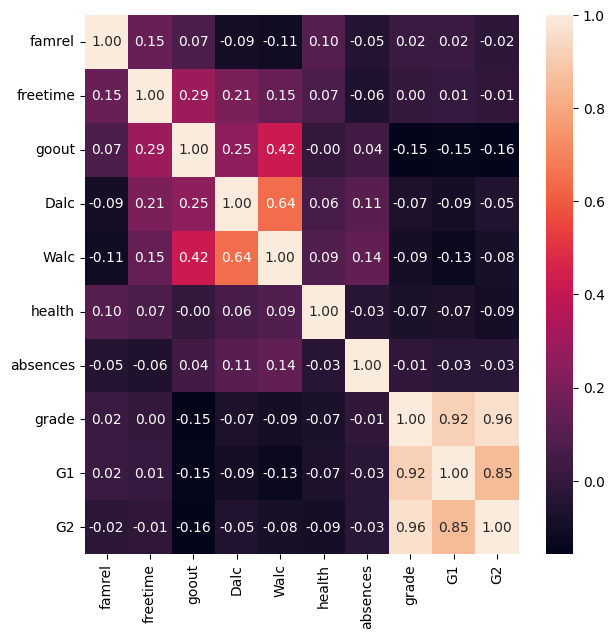

In [6]:
corr_df = df.select_dtypes(exclude=object).corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr_df, annot=True, fmt='.2f');
plt.show();

같은 성적 데이터인 G1, G2, grade 간 상관성이 높기 때문에,  
변수 활용에 유의가 필요해 보인다.  

그 외 다른 수치형 변수들 간의 상관성은 높지 않기 때문에  
분석에 모두 활용 가능해 보인다.

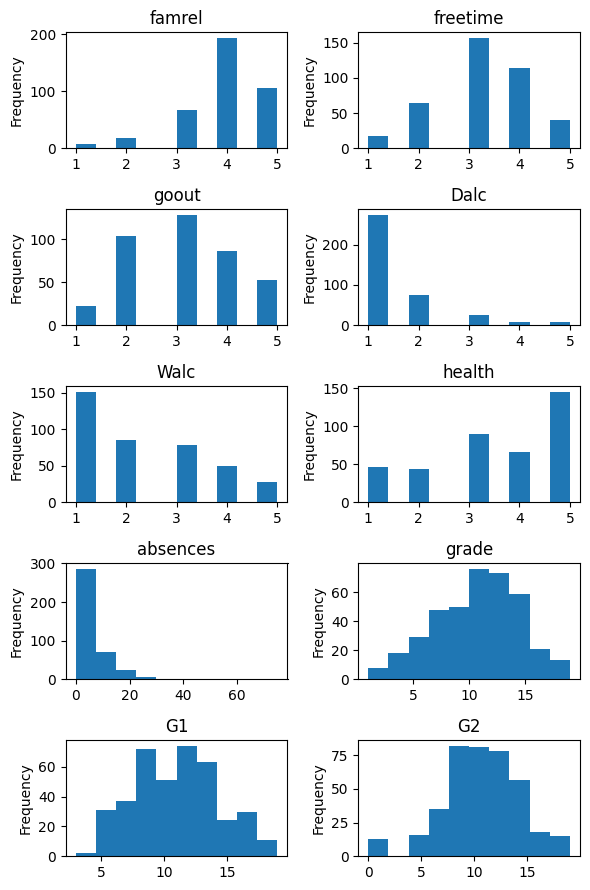

In [7]:
num_df = df.select_dtypes(exclude=object)


plt.figure(figsize=(6, 9))

for idx, col in enumerate(num_df.columns):
    plt.subplot(5, 2, idx + 1)
    plt.title(col)
    df[col].plot(kind='hist')

plt.tight_layout()
plt.show();

famrel, Dalc, Walc, health, absences의 분포가 쏠려 있는 것을 확인할 수 있다.  
성적 변수 grade, G1, G2를 제외한 각 변수의 최빈값을 특정할 수 있어 보인다.

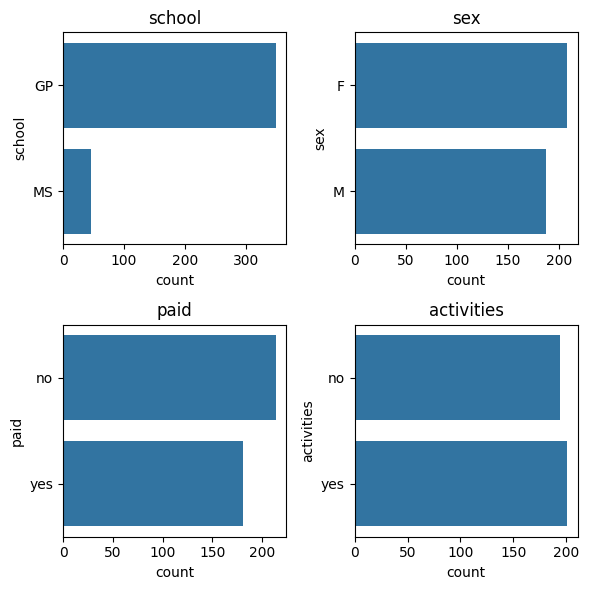

In [8]:
obj_df = df.select_dtypes(include=object)

plt.figure(figsize=(6, 6))
for idx, col in enumerate(obj_df.columns):
    plt.subplot(2, 2, idx + 1)
    plt.title(col)
    sns.countplot(df[col])

plt.tight_layout()
plt.show();

명목형 변수는 4개 모두 이진 형태의 변수로 이루어져 있고,  
이중 school 변수의 값이 특히 불균형한 것을 확인할 수 있다.

obejct 타입 변수는 분석에 활용할 때 원핫인코딩 또는  
레이블 인코딩으로 변환하여 활용해야 한다.

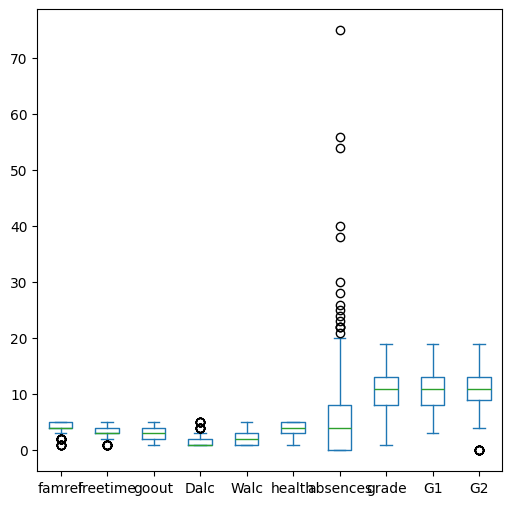

In [9]:
num_df.plot(kind='box', figsize=(6, 6));

In [10]:
df[df.absences > df.absences.quantile(0.95)]

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
40,GP,F,no,yes,3.0,3.0,NaN,1.0,2.0,3.0,25.0,9,7,10
74,GP,F,yes,yes,4.0,3.0,3.0,2.0,4.0,5.0,54.0,11,11,12
103,GP,F,yes,no,4.0,3.0,5.0,1.0,1.0,2.0,26.0,6,7,6
118,GP,M,no,yes,5.0,2.0,4.0,1.0,4.0,5.0,20.0,8,9,7
183,GP,F,no,yes,5.0,3.0,3.0,2.0,3.0,1.0,56.0,9,9,9
198,GP,F,no,no,4.0,2.0,4.0,2.0,3.0,2.0,24.0,18,18,18
205,GP,F,yes,no,4.0,4.0,3.0,3.0,4.0,5.0,28.0,9,10,9
216,GP,F,yes,no,3.0,4.0,5.0,2.0,4.0,1.0,22.0,5,6,6
237,GP,F,no,no,4.0,5.0,2.0,1.0,1.0,5.0,20.0,12,13,12
260,GP,F,yes,no,3.0,1.0,2.0,1.0,3.0,2.0,21.0,18,17,18


absences 변수의 몇몇 값이 지나치게 커 이상값으로 보일 수 있으나,  
실제로 관측이 가능하다고 판단되므로 정상값으로 활용 가능해 보인다.

### 1 - 2 결측치를 식별/예측하는 두 가지 방법을 쓰고
### 이를 선택한 이유를 설명

결측치를 식별/예측하는 방법으로 두 가지는 아래와 같다.

1. 단순대치법 : 해당 변수의 수치형의 경우 평균이나 중앙값,  
   명목형의 경우 최빈값 등으로 결측값을 보간하는 방법
2. K-NN 대체법 : 수치형 변수에만 활용 가능한 대체법으로, K-NN 알고리즘을  
   통해 결측값을 예측하여 보간하는 방법

이 중에서 하나를 선택하자면 최빈값을 활용해 단순대치법을 사용하는 것이 좋아 보인다.  
결측값이 존재했던 famrel, freetime, goout, Dalc, Walc, health, absences  
변수 모두 이산형의 수치형 변수이고, 최빈값을 특정할 수 있기 때문이다.

In [11]:
fill_col = ['famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

for col in fill_col:
    df[col] = df[col].fillna(df[col].mode()[0])

df.isna().sum()

school        0
sex           0
paid          0
activities    0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
grade         0
G1            0
G2            0
dtype: int64

### 1 - 3 범주형 변수 인코딩이 필요한 경우를 식별하고
### 변환 적용 및 이를 선택한 이유를 설명

In [12]:
obj_df

,school,sex,paid,activities
0,GP,F,no,no
1,GP,F,no,no
2,GP,F,yes,no
3,GP,F,yes,yes
4,GP,F,yes,no
...,...,...,...,...
390,MS,M,yes,no
391,MS,M,no,no
392,MS,M,no,no
393,MS,M,no,no


object 타입인 school, sex, paid, activities 변수는 인코딩이 필요하다.  
4개 변수 모두 참 또는 거짓으로 나타낼 수 있는 이진 변수이므로  
컬럼이 증가하는 원핫인코딩 대신 레이블 인코딩을 적용한다.

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

obj_col = obj_df.columns

le = LabelEncoder()

for col in obj_col:
    df[col] = le.fit_transform(df[col])

df

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
0,0,0,0,0,4.0,3.0,4.0,1.0,1.0,3.0,6.0,6,5,6
1,0,0,0,0,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5,5,5
2,0,0,1,0,4.0,3.0,2.0,2.0,3.0,3.0,10.0,8,7,8
3,0,0,1,1,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15,15,14
4,0,0,1,0,4.0,3.0,2.0,1.0,2.0,5.0,4.0,9,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,1,0,5.0,5.0,4.0,4.0,5.0,4.0,11.0,9,9,9
391,1,1,0,0,2.0,4.0,5.0,3.0,4.0,2.0,3.0,15,14,16
392,1,1,0,0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,8,10,8
393,1,1,0,0,4.0,4.0,1.0,3.0,4.0,5.0,0.0,11,11,12


### 1 - 4 데이터 분할 방법 2가지를 쓰고, 적절한 분할을 적용
### 및 이를 선택한 이유 설명

1. 무작위 분할 방법 - 주어진 데이터셋을 7:3, 8:2 등 특정 비율로 학습용과  
   검증용으로 나누어 활용하는 방법
2. 층화 추출 방법 - 학습 데이터와 검증 데이터로 분할할 때, 정답 데이터의  
   균형 정도(정답 클래스의 비율)가 동일하도록 분할하는 방법

정답으로 활용할 종속변수인 grade는 연속형이라고 볼 수 있으므로  
회귀분석을 진행할 예정이므로 무작위 분할 방법을 통해  
데이터셋을 정답 7:검증 3으로 분할한다.

In [14]:
x = df.drop(columns='grade')
y = df[['grade']]

train_x, test_x, train_y, test_y = train_test_split(x, y)

train_x.shape, test_x.shape

((296, 13), (99, 13))

### 1 - 5 SVM, XGBoost, RandomForest 3개의 알고리즘 공통점을 작성하고,
### 학생성적 예측 분석에 적합한 알고리즘인지 설명

알고리즘의 공통점

1. 회귀분석과 분류분석 모두 가능한 알고리즘이다.
2. 비선형 데이터에도 적용 가능한 알고리즘이다.
3. 과적합 방지를 위한 하이퍼파라미터를 설정해야 한다.

3개의 알고리즘은 회귀분석에 적용 가능하고,  
비선형 데이터에도 적용이 가능한 공통점이 있으므로  
학생성적 예측 분석에 적합해 보인다.

### 1 - 6 3가지 모두 모델링하고 가정 적합한 알고리즘 선택
### 이를 선택한 이유와 모델의 한계점 및 보완 가능한 부분 설명
### 현업 주의 사항 기술

In [15]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as xgbr

In [16]:
svc = SVC()
rf = RandomForestRegressor()
xgb = xgbr()

In [17]:
svc.fit(train_x, train_y)
rf.fit(train_x, train_y)
xgb.fit(train_x, train_y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [18]:
import time

for md in [('svc', svc), ('rf', rf), ('xgb', xgb)]:
    start = time.time()
    print(f'Score of {md[0]} : {cross_val_score(md[1], x, y, cv=5, n_jobs=-1).mean()}')
    end = time.time()
    print(f'Time : {end - start}\n')

Score of svc : 0.37215189873417726
Time : 2.89400315284729

Score of rf : 0.9535106135781174
Time : 2.2634236812591553

Score of xgb : 0.9429541110992432
Time : 2.2715184688568115



모델의 한계점 확인을 위해 상관성이 높았던  
G1, G2 변수를 제외하고 교차검증을 진행해본다.

In [19]:
second_x = x.iloc[:, :-2]
second_x

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,0,0,0,4.0,3.0,4.0,1.0,1.0,3.0,6.0
1,0,0,0,0,5.0,3.0,3.0,1.0,1.0,3.0,4.0
2,0,0,1,0,4.0,3.0,2.0,2.0,3.0,3.0,10.0
3,0,0,1,1,3.0,2.0,2.0,1.0,1.0,5.0,2.0
4,0,0,1,0,4.0,3.0,2.0,1.0,2.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,1,0,5.0,5.0,4.0,4.0,5.0,4.0,11.0
391,1,1,0,0,2.0,4.0,5.0,3.0,4.0,2.0,3.0
392,1,1,0,0,5.0,5.0,3.0,3.0,3.0,3.0,3.0
393,1,1,0,0,4.0,4.0,1.0,3.0,4.0,5.0,0.0


In [20]:
for md in [('svc', svc), ('rf', rf), ('xgb', xgb)]:
    start = time.time()
    print(f'Score of {md[0]} : {cross_val_score(md[1], second_x, y, cv=5, n_jobs=-1).mean()}')
    end = time.time()
    print(f'Time : {end - start}\n')

Score of svc : 0.09873417721518987
Time : 2.274522066116333

Score of rf : -0.09739263641224001
Time : 0.3544771671295166

Score of xgb : -0.4860018253326416
Time : 0.31457090377807617



가장 적합한 모델로 Random Forest 회귀 분석 모델을 선정한다.  
5번의 교차검증 평균 정확도가 가장 높았고,  
검증시간 측정 결과 역시 가장 빨랐기 때문이다.

모델의 한계점으로는 상관계수가 높았던 G1, G2 변수를  
제외했을 경우에는 분석이 의미가 없는 수준으로 정확도가  
떨어지는 것을 확인했다.

이런 부분을 보완하기 위해 초매개변수를 튜닝하고,  
기존 변수로부터 파생변수를 생성하여 활용하는  
방법 등으로 보완이 가능해 보인다.

현업에서는 데이터가 추가되거나 제거해야 하는 경우가  
수시로 발생할 수 있으므로 분석이 필요한 데이터를  
기획자 혹은 데이터 관리자와 협의하여 확정할 필요가 있다.  
최초 분석간 사용한 컬럼과 이후 분석할 컬럼이 다르다면  
그 동안의 모델 학습의 의미가 없어지기 때문이다.  
현업에서 분석할 경우 이런 부분들을 주의하여  
분석에 임할 필요가 있다.

### 2 - 1 데이터를 8:2로 분할하고 선형 회귀 적용
### 결정계수 및 RMSE 구하기

In [21]:
import mglearn

x, y = mglearn.datasets.load_extended_boston()

In [22]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2025)

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
from sklearn.metrics import mean_squared_error

lr = LinearRegression()

lr.fit(train_x, train_y)

print(f'결정계수 : {lr.score(test_x, test_y):.3%}')
print(f'RMSE : {np.sqrt(mean_squared_error(test_y, lr.predict(test_x))):.3f}')

결정계수 : 57.193%
RMSE : 5.986


### 2 - 2 데이터를 8:2로 분할하고 Ridge 회귀 적용
### 결정계수 및 RMSE 구하기
### alpha 값을 0 ~ 1 까지 0.1 단위로 탐색하여 결정계수 개선

In [25]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

l1 = Ridge()
l2 = Lasso()

al_range = np.arange(0, 1.1, 0.1)
al_range = list(map(lambda x: round(float(x), 2), al_range))

In [26]:
params = {"alpha": al_range}

gs = GridSearchCV(l1, params, scoring='r2')

gs.fit(train_x, train_y)

print(f"결정계수가 가장 높은 alpha : {gs.best_params_}")

결정계수가 가장 높은 alpha : {'alpha': 0.1}


In [27]:
l1 = Ridge(**gs.best_params_)

l1.fit(train_x, train_y)

print(f'결정계수 : {l1.score(test_x, test_y):.3%}')
print(f'RMSE : {np.sqrt(mean_squared_error(test_y, l1.predict(test_x))):.3f}')

결정계수 : 84.901%
RMSE : 3.555


### 2 - 3 데이터를 8:2로 분할하고 Lasso 회귀 적용
### 결정계수 및 RMSE 구하기
### alpha 값을 0 ~ 1 까지 0.1 단위로 탐색하여 결정계수 개선

In [28]:
params = {"alpha": al_range}

gs = GridSearchCV(l2, params, scoring='r2')

gs.fit(train_x, train_y)

print(f"결정계수가 가장 높은 alpha : {gs.best_params_}")

결정계수가 가장 높은 alpha : {'alpha': 0.0}


In [29]:
l2 = Lasso(**gs.best_params_)

l2.fit(train_x, train_y)

print(f'결정계수 : {l2.score(test_x, test_y):.3%}')
print(f'RMSE : {np.sqrt(mean_squared_error(test_y, l2.predict(test_x))):.3f}')

결정계수 : 79.479%
RMSE : 4.145


### 3 다항 회귀분석 시각화
#### 단순 선형 회귀를 다항 회귀로 3차까지 적용시켜
#### 계수를 구하고 3차항을 적용한 모델의 Scatter 플롯과 기울기 선

In [30]:
m = 500
x = 6 * np.random.rand(m, 1) - 3
y = x ** 3 + x ** 2 + x + np.random.rand(m, 1)

In [31]:
line = np.linspace(-3, 3, 500, endpoint=False).reshape(-1, 1)

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [33]:
poly = PolynomialFeatures(degree=3)

x_poly = poly.fit_transform(x)
line_poly = poly.transform(line)

In [34]:
lr = LinearRegression()

lr.fit(x_poly, y)
pred = lr.predict(line_poly)

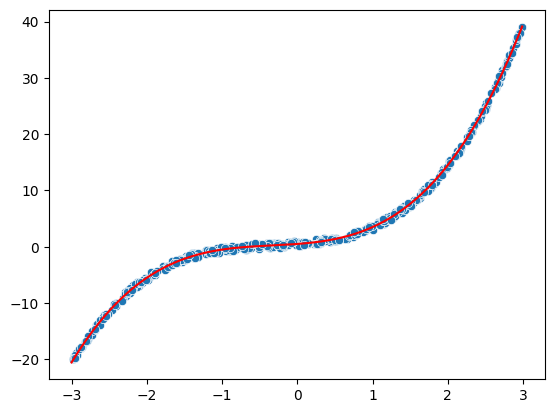

In [35]:
plt.plot(line, pred, color='r')
sns.scatterplot(x=x.reshape(-1), y=y.reshape(-1))

plt.show();

### 4 ANOVA 분석 - 변수 3개(AveragePrice, type, region)의
### 이원 분산분석을 수행하고 통계표 작성

In [36]:
df = pd.read_csv('../Edu/code/data/avocado.csv', index_col=0)

In [37]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [38]:
avo_df = df[['AveragePrice', 'type', 'region']]
avo_df.head()

,AveragePrice,type,region
0,1.33,conventional,Albany
1,1.35,conventional,Albany
2,0.93,conventional,Albany
3,1.08,conventional,Albany
4,1.28,conventional,Albany


In [39]:
ans_df = avo_df[avo_df.region.isin(['Orlando', 'Boston', 'Chicago'])]
ans_df

,AveragePrice,type,region
0,1.13,conventional,Boston
1,1.07,conventional,Boston
2,1.01,conventional,Boston
3,1.02,conventional,Boston
4,1.19,conventional,Boston
...,...,...,...
7,1.36,organic,Orlando
8,1.67,organic,Orlando
9,1.53,organic,Orlando
10,1.55,organic,Orlando


### 상호작용 효과 검정에 대한 가설 수립
- 귀무가설 H0 : region과 type 간 상호작용 효과는 없다.
- 대립가설 H1 : region과 type 간 상호작용 효과가 있다.

### 주효과 검정에 대한 가설 수립
- 귀무가설 H0 : type에 따른 AveragePrice의 분산은 같다.
- 대립가설 H1 : type에 따른 AveragePrice의 분산은 다르다.
- 귀무가설 H0 : region에 따른 AveragePrice의 분산은 같다.
- 대립가설 H1 : region에 따른 AveragePrice의 분산은 다르다.

In [40]:
avg_price = ans_df['AveragePrice']
avo_type = ans_df['type']
avo_region = ans_df['region']

In [41]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [42]:
formula = 'avg_price ~ C(avo_type) * C(avo_region)'
model = ols(formula,  ans_df).fit()
anova_tbl = anova_lm(model, typ=2)

#### ANOVA 분석의 통계표는 아래와 같다.

In [43]:
anova_tbl

,sum_sq,df,F,PR(>F)
C(avo_type),56.111007,1.0,828.218296,1.989417e-133
C(avo_region),0.432136,2.0,3.189242,4.161918e-02
C(avo_type):C(avo_region),1.878817,2.0,13.866003,1.146622e-06
Residual,68.291047,1008.0,NaN,NaN


In [44]:
anova_tbl['PR(>F)'].round(4)

C(avo_type)                  0.0000
C(avo_region)                0.0416
C(avo_type):C(avo_region)    0.0000
Residual                        NaN
Name: PR(>F), dtype: float64

### 상호작용 검정 결과 : C(avo_type):C(avo_region) 행
P-Value가 0.05 미만이므로 유의수준 5% 하에서 귀무가설을 기각하고  
대립가설을 채택, 통계적으로 region과 type 간 상호작용 효과가 있다.

### 주효과 검정 결과

P-Value가 각각 0.05 미만이므로 region과 type 모두 유의수준 5% 하에서  
귀무가설을 기각하고 대립가설을 채택, 통계적으로  
type에 따른 AveragePrice의 평균은 다르고,  
region에 따른 AveragePrice의 평균 역시 다르다.

즉 AveragePrice는 type 그리고 region에 따라 차이가 난다.
따라서 사후검정을 진행한다.

### 사후검정

- 사후검정 귀무가설 : 집단들 간 평균이 동일하다.
- 사후검정 대립가설 : 집단들 간 평균이 다르다.

In [48]:
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd

ans_df['group'] = ans_df['type'] + "_" + ans_df['region']

mc = MultiComparison(ans_df['AveragePrice'], ans_df['group'])
tukey_result = mc.tukeyhsd(alpha=0.05)
print(tukey_result)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
 conventional_Boston conventional_Chicago    0.065 0.1971 -0.0159  0.1458  False
 conventional_Boston conventional_Orlando  -0.0899 0.0191 -0.1708 -0.0091   True
 conventional_Boston       organic_Boston    0.453    0.0  0.3722  0.5339   True
 conventional_Boston      organic_Chicago   0.4398    0.0   0.359  0.5207   True
 conventional_Boston      organic_Orlando   0.4936    0.0  0.4128  0.5745   True
conventional_Chicago conventional_Orlando  -0.1549    0.0 -0.2358 -0.0741   True
conventional_Chicago       organic_Boston    0.388    0.0  0.3072  0.4689   True
conventional_Chicago      organic_Chicago   0.3749    0.0   0.294  0.4557   True
conventional_Chicago      organic_Orlando   0.4286    0.0  0.3478  0.5095   True
conventional_Orlando       o

수정된 P-value에 따라 conventional_Boston - conventional_Chicago,  
organic_Boston - organic_Chicago,  
organic_Boston - organic_Orlando,  
organic_Chicago - organic_Orlando,  

집단 간 평균이 동일한 것을 확인할 수 있다.

In [49]:
mc = MultiComparison(ans_df['AveragePrice'], ans_df['type'])
tukey_result = mc.tukeyhsd(alpha=0.05)
print(tukey_result)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
   group1     group2 meandiff p-adj lower  upper reject
-------------------------------------------------------
conventional organic   0.4705   0.0 0.4379 0.503   True
-------------------------------------------------------


개별 그룹으로 보면 type 변수는 p-value가 0.05 이하이므로 귀무가설을 기각하고  
대립가설을 채택, conventional과 organic은 집단 간 평균이 통계적으로 다르다.

In [50]:
mc = MultiComparison(ans_df['AveragePrice'], ans_df['region'])
tukey_result = mc.tukeyhsd(alpha=0.05)
print(tukey_result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 Boston Chicago   0.0259 0.6073 -0.0379 0.0897  False
 Boston Orlando  -0.0247 0.6356 -0.0885 0.0391  False
Chicago Orlando  -0.0506  0.151 -0.1144 0.0132  False
-----------------------------------------------------


region 변수는 집단간 p-value가 0.05을 초과하므로 귀무가설을 채택,    
집단 간 평균이 통계적으로 같다.

                                                        마지막 페이지 16 페이지. 끝.